In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [97]:
data = pd.read_excel("estimate_power_consumption.xlsx")
data.head()

,unit_no,maxa,maxr,active,reactive,consumption
0,1,1322,1043,26815.0,568.0,264.452105
1,2,1316,1032,24773.0,253.0,39.563698
2,4,1345,1005,26820.0,112.0,191.193007
3,6,1336,1013,25470.0,150.0,185.514004
4,1,1320,1038,26875.0,636.0,216.559192


In [98]:
data.isnull().sum()

unit_no        0
maxa           0
maxr           0
active         0
reactive       0
consumption    0
dtype: int64

In [99]:
X = data[["unit_no","maxa","maxr","active","reactive"]]
y = data[["consumption"]]
y

,consumption
0,264.452105
1,39.563698
2,191.193007
3,185.514004
4,216.559192
...,...
994,2260.499827
995,2399.545032
996,165.448196
997,174.534605


In [100]:
X

,unit_no,maxa,maxr,active,reactive
0,1,1322,1043,26815.000000,568.000000
1,2,1316,1032,24773.000000,253.000000
2,4,1345,1005,26820.000000,112.000000
3,6,1336,1013,25470.000000,150.000000
4,1,1320,1038,26875.000000,636.000000
...,...,...,...,...,...
994,8,1340,1007,27237.512695,125.000000
995,9,1347,1007,27490.889893,145.016361
996,1,1314,1035,26708.000000,262.000000
997,2,1309,1022,26580.000000,232.000000


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [102]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Tuning Hyperparameters by using GridSearchCV

In [103]:
# Define the SVR model
svr = SVR()

# Define the hyperparameters to tune
param_grid = {'kernel': ['linear', 'rbf', 'poly'],
              'C': [0.001,0.01,0.1, 1, 10,100,1000],
              'epsilon': [0.001,0.01,0.1, 1, 10,100,1000]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(svr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best hyperparameters: {'C': 1000, 'epsilon': 100, 'kernel': 'rbf'}
Best score: 0.877717160774926


# Evaluation

In [104]:
svr = SVR(C=1000, epsilon=100, kernel='rbf')
svr.fit(X_train,y_train)
y_pred=svr.predict(X_test)

In [105]:
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 94678.38485289451
R-squared: 0.8509291597342354


# Trying dimention reduction for the model

In [106]:
# Apply PCA to reduce the number of features to 3
pca = PCA(n_components=X.shape[1])
X_train_pca = pca.fit_transform(X_train)

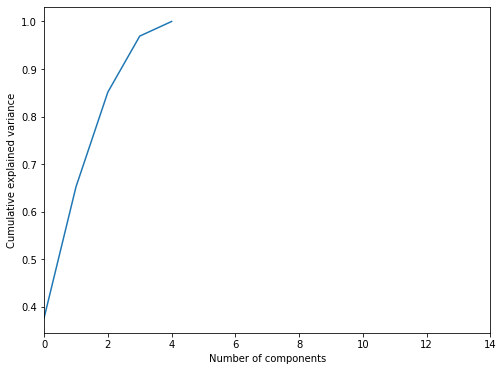

In [107]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

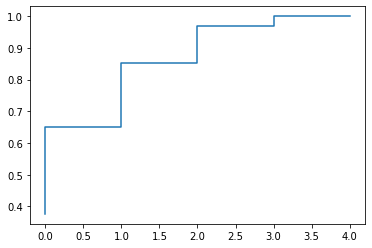

In [108]:
cumulative=np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))],cumulative)
plt.show()

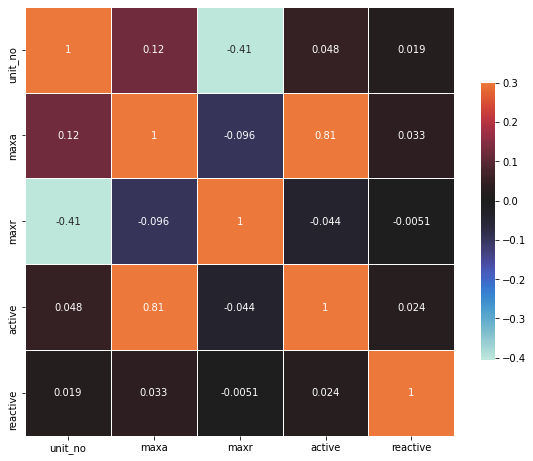

In [111]:
plt.figure(figsize=(8,8))
sns.heatmap(X.corr(),vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.tight_layout()
plt.show()

In [112]:
pca=PCA().fit(X_train)
print(pca.explained_variance_ratio_)
print()
print(X.columns.values.tolist())

[0.37622865 0.27562993 0.19950301 0.11785149 0.03078692]

['unit_no', 'maxa', 'maxr', 'active', 'reactive']


In [113]:
pipeline = Pipeline([
    ('pca', PCA(n_components=X.shape[1])),
    ('svr', SVR(C=1000, epsilon=100, kernel='rbf'))
])

In [114]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [115]:
# Calculate Mean Squared Error (MSE) of the predictions 
mse=mean_squared_error(y_pred,y_test)
r2=r2_score(y_pred,y_test)
print("Mean squared error:",mse)
print("R-squared:",r2)

Mean squared error: 94678.38485289413
R-squared: 0.8509291597342359
